In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from scipy import stats

# www.oxford.ac.uk

In [2]:
dfAllHops = pd.read_csv("experimentos/www.oxford.ac.uk-allHops.csv", sep=",")

with open('experimentos/www.oxford.ac.uk-json.json') as json_data:
    lstDic = json.load(json_data)

lstRtt = [dic['rtt'] for dic in lstDic]

In [19]:
def promedio(lst):
    return sum(lst)/len(lst)

def desvioEstandar(lst):
    prom = promedio(lst)
    return (sum([(x-prom)**2 for x in lst])/(len(lst)-1))**0.5

def calcMedia(lstRttes):
    suma = 0.0
    for rtt,_,_ in lstRttes:
        suma += rtt
    return suma/len(lstRttes)


def calcDesvioEstandar(lstRttes, media):
    suma = 0.0
    for rtt,_,_ in lstRttes:
        suma += (rtt - media)**2
    return (suma/(len(lstRttes)-1))**(0.5)


def calcValorAbsDesv(lstRttes, media):
    for i in range(len(lstRttes)):
        lstRttes[i][2] = abs(lstRttes[i][0] - media)


def calcTau(n):
    #Studnt, p<0.05, 2-tail, alpha=0.05
    t = stats.t.ppf(1-0.025, n-2)
    return (t*(n-1)) / ((n**0.5)*((n-2 + t**2)**0.5))


def anteriorNoNull(lst, idxNull):
    for i in range(idxNull-1, 0, -1):
        if lst[i]['ip_address'] != 'null':
            return i


def posteriorNoNull(lst, idxNull):
    for i in range(idxNull+1, len(lst)):
        if lst[i]['ip_address'] != 'null':
            return i


def dameRtts(lst):
    # si hay un null calcula el promedio del anterior no null y el siguiente no null
    lstIdxNull = []
    for i in range(len(lst)):
        if lst[i]['ip_address'] == 'null':
            lstIdxNull.append(i)
    rtt = []
    for i in range(len(lst)):
        if i not in lstIdxNull:
            rtt.append(lst[i]['rtt'])
        else:
            idxAnt = anteriorNoNull(lst,i)
            idxPost = posteriorNoNull(lst,i)
            rtt.append((lst[idxAnt]['rtt']+lst[idxPost]['rtt'])/2)
    return rtt, lstIdxNull


def cimbala(lst):
    # rttes, idx, absolute value of deviation
    rttcal, lstIdxNull = dameRtts(lst)
    lstRttes = [[abs(rttcal[i] - rttcal[i+1]), i, 0] for i in range(len(rttcal)-1)]
    lstRttES = [x[0] for x in lstRttes]
    outlierIdx = []
    hayOutlier = True
    while(hayOutlier):
        hayOutlier = False
        media = calcMedia(lstRttes)
        desvEst = calcDesvioEstandar(lstRttes, media)
        calcValorAbsDesv(lstRttes, media)
        tau = calcTau(len(lstRttes))
        tauS = desvEst*tau
        for i in range(len(lstRttes)):
            if lstRttes[i][2] > tauS:
                hayOutlier = True
                outlierIdx.append(lstRttes[i][1])
                lstRttes.pop(i)
                break
    return (outlierIdx, lstIdxNull, lstRttES)


outlierIdx, lstIdxNull, lstRttes = cimbala(lstDic)
print outlierIdx
print lstRttes

lstIdx1 = range(20)
lstIdxNull = [19,20]
lstIdx2 = [20,21]
lstRttes1 = [lstRttes[i] for i in lstIdx1]
lstRttesNull = [lstRttes[i] for i in lstIdxNull]
lstRttes2 = [lstRttes[i] for i in lstIdx2]
print lstIdx1
print lstIdxNull
print lstIdx2

lstStr = []
for i in range(1, len(lstRttes)+1):
    lstStr.append(str(i)+'y'+str(i+1))
print lstStr

[7, 21]
[1.0323990147783366, 0.5455085714285612, 1.5316700000000143, 0.28999000000000663, 0.30691000000002155, 0.14528999999987668, 0.2721600000002624, 2.5536600000002405, 0.37252565656554637, 0.28864565656572694, 0.04157999999999795, 0.8743400000004034, 0.8182400000003671, 1.1126400000000292, 0.5249399999997877, 0.4182200000005647, 0.27304000000021844, 1.5186973737370248, 0.9114215842635147, 1.4712978947369724, 1.4712978947369706, 3.284939999999777]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[19, 20]
[20, 21]
['1y2', '2y3', '3y4', '4y5', '5y6', '6y7', '7y8', '8y9', '9y10', '10y11', '11y12', '12y13', '13y14', '14y15', '15y16', '16y17', '17y18', '18y19', '19y20', '20y21', '21y22', '22y23']


## RTT entre saltos (restar los valores promediados a cada salto)

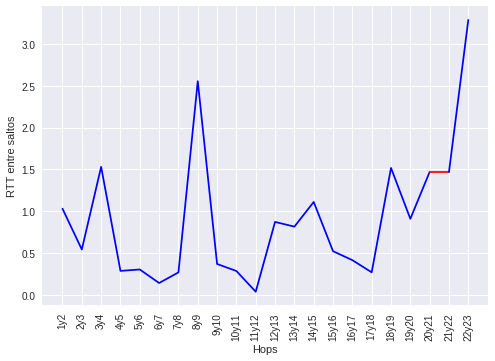

In [24]:
plt.plot(lstIdx1, lstRttes1, 'blue')
plt.plot(lstIdxNull, lstRttesNull, 'red')
plt.plot(lstIdx2, lstRttes2, 'blue')

plt.ylabel('RTT entre saltos')
plt.xlabel('Hops')
plt.xticks(range(len(lstRttes)+1), lstStr, rotation=90)
plt.show()

## RTT entre saltos en la ruta, graficar el valor (X i − X̄)/S

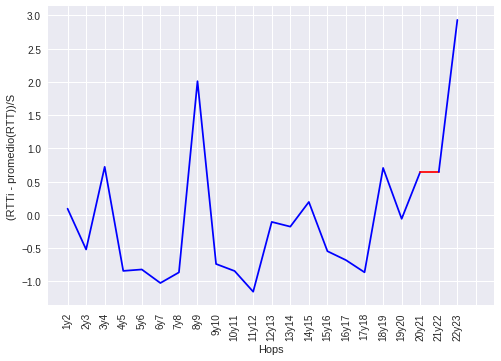

In [25]:
prom = promedio(lstRttes1 + lstRttesNull + lstRttes2)
s = desvioEstandar(lstRttes1 + lstRttesNull + lstRttes2)
lstVal1 = [(x-prom)/s for x in lstRttes1]
lstValNull = [(x-prom)/s for x in lstRttesNull]
lstVal2 = [(x-prom)/s for x in lstRttes2]

plt.plot(lstIdx1, lstVal1, 'blue')
plt.plot(lstIdxNull, lstValNull, 'red')
plt.plot(lstIdx2, lstVal2, 'blue')
plt.ylabel('(RTTi - promedio(RTT))/S')
plt.xlabel('Hops')
plt.xticks(range(len(lstRtt)+1), lstStr, rotation=90)
plt.show()

## Porcentaje que no responden los Time exceeded

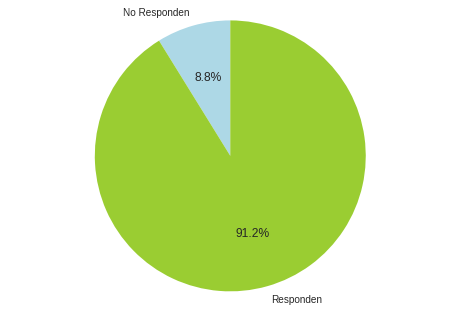

In [26]:
maxVal = max(set(dfAllHops['hop_num']))
lstTE = dfAllHops[dfAllHops['hop_num'] < maxVal]['ip_address']
cantNull = 0
for ip in lstTE:
    if ip == 'null':
        cantNull+=1

porcentajes = [cantNull, len(lstTE) - cantNull]

labels = 'No Responden', 'Responden'
explode = [0,0]

fig1, ax1 = plt.subplots()
ax1.pie(porcentajes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['lightblue', 'yellowgreen'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Cantidad de Ips por salto

In [27]:
hops = list(set(dfAllHops['hop_num']))
hops.sort()
lstSetIps = []
for h in hops:
    lstSetIps.append(set(dfAllHops[(dfAllHops['hop_num'] == h) & (dfAllHops['ip_address'] != 'null')]['ip_address']))

print lstSetIps
for s in lstSetIps:
    print len(s),

[set(['192.168.0.1']), set(['192.168.2.1']), set(['172.16.128.1']), set(['10.0.13.1']), set(['186.0.137.1']), set(['190.181.113.73']), set(['190.12.119.105']), set(['195.22.220.237']), set(['195.22.199.179', '89.221.41.175']), set(['80.239.193.161']), set(['62.115.119.230', '62.115.120.176']), set(['62.115.122.60', '80.91.246.69']), set(['62.115.141.197', '62.115.121.61']), set(['62.115.148.159']), set(['146.97.35.197']), set(['146.97.33.2']), set(['146.97.37.194']), set(['193.63.108.94']), set(['193.63.108.98']), set(['193.63.109.90']), set([]), set(['192.76.32.66', '192.76.32.62']), set(['129.67.242.155', '129.67.242.154'])]
1 1 1 1 1 1 1 1 2 1 2 2 2 1 1 1 1 1 1 1 0 2 2


## Saltos internacionales

In [28]:
print [dic['salto_intercontinental'] for dic in lstDic]

[u'false', u'false', u'false', u'false', u'false', u'false', u'false', u'false', True, u'false', u'false', u'false', u'false', u'false', u'false', u'false', u'false', u'false', u'false', u'false', u'null', u'false', True]
